# LLM Project — Email Routing (5 departments)

This notebook is the **main deliverable**. It loads the dataset via `datapreparation.py`, trains a **DistilBERT** classifier, and reports **Accuracy**, **Inference Time**, and **Memory**.

**Note:** Two other agents are required by the project specification (GPT-2 prompting and GPT-2 + LoRA). This notebook includes **placeholders** for them, but the implementation will be added in the `src/` step.


## 0. Environment / GPU check
If you have an NVIDIA GPU, this project can run much faster.

If training is slow:
- verify CUDA is available (`torch.cuda.is_available()`)
- free VRAM (close other Python notebooks / apps using the GPU)
- reduce batch size to fit 4GB GPUs (RTX 3050 Laptop).


In [1]:
import os, time, json, random
from pathlib import Path

import numpy as np
import torch
import psutil

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Paths
ROOT = Path('.').resolve()
OUT_METRICS = ROOT / 'outputs' / 'metrics'
OUT_FIG = ROOT / 'outputs' / 'figures'
OUT_METRICS.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)



# --------------------------------------------------
# Device selection (CPU / GPU)
# --------------------------------------------------
# Priority order:
# 1) MANUAL_DEVICE (set directly in notebook)
# 2) Environment variable ROUTER_DEVICE
# 3) Automatic (cuda if available else cpu)
# --------------------------------------------------

# === 1) Manual override (EDIT HERE IF NEEDED) ===
MANUAL_DEVICE = "cuda"    # "cpu", "cuda", or None
# MANUAL_DEVICE = "cuda"
# MANUAL_DEVICE = None


# === 2) Environment variable ===
ENV_DEVICE = os.environ.get("ROUTER_DEVICE", "auto").lower()


# === Resolution logic ===
if MANUAL_DEVICE is not None:
    DEVICE_STR = MANUAL_DEVICE.lower()
else:
    DEVICE_STR = ENV_DEVICE

if DEVICE_STR == "auto":
    DEVICE_STR = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE_STR == "cuda" and not torch.cuda.is_available():
    print("⚠️ CUDA requested but not available, falling back to CPU.")
    DEVICE_STR = "cpu"

assert DEVICE_STR in {"cpu", "cuda"}, f"Invalid device: {DEVICE_STR}"

device = torch.device(DEVICE_STR)

print(f"Device: {device}")
print("CUDA available:", torch.cuda.is_available())
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

def ram_mb() -> float:
    return psutil.Process(os.getpid()).memory_info().rss / (1024**2)


Device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Patch — robust label parsing for GPT-2 prompting

In `src/agents/gpt2_prompting.py`, replace your `parse_department(...)` with the **strict** version below.
This avoids false matches caused by labels appearing inside the prompt.

In [2]:

# Copy/paste this function into src/agents/gpt2_prompting.py (replace the old parse_department)

import re

def parse_department(text: str, label_list: list[str]) -> int | None:
    """
    Return label id if a label is predicted exactly (robust parsing).
    IMPORTANT: apply to the model generated answer only, not the full prompt.
    """
    if not text:
        return None

    t = text.strip().lower()
    t = re.sub(r"[^\w\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()

    for i, lab in enumerate(label_list):
        if t == lab.lower().strip():
            return i
    return None

## 1. Dataset and problem setup

Goal: **route an incoming customer email** to one of 5 departments (*queues*):
1) Billing and Payments  
2) Customer Service  
3) General Inquiry  
4) Sales and Pre‑Sales  
5) Technical Support

We use the dataset `Tobi-Bueck/customer-support-tickets` and focus on the `subject` + `body` fields as input text.


In [3]:
from datapreparation import load_and_prepare_data

train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

print('Labels:', label_list)
print('Train size:', len(train_ds), '| Val size:', len(val_ds), '| Test size:', len(test_ds))


Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})
Labels: ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Sales and Pre-Sales', 'Technical Support']
Train size: 13249 | Val size: 1656 | Test size: 1657


### Sanity checks

We inspect:
- label distribution (to spot class imbalance),
- a few examples (to confirm the fields are correctly loaded),
- dataset sizes after the train/val/test split.


In [4]:
from collections import Counter

print('Train label distribution:')
print(Counter(train_ds['queue']))

# Show a few samples
for i in range(3):
    ex = train_ds[i]
    print('\n--- Example', i, '---')
    print('queue:', ex.get('queue'))
    print('subject:', (ex.get('subject') or '')[:120])
    print('body:', (ex.get('body') or '')[:200])


Train label distribution:
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})

--- Example 0 ---
queue: Customer Service
subject: Guidance on Investment Data Analytics
body: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions.

--- Example 1 ---
queue: Sales and Pre-Sales
subject: 
body: Dear customer support, the data analytics tool is failing to process investment data efficiently. The problem might be due to software compatibility issues. After updating the associated software devi

--- Example 2 ---
queue: Customer Service
subject: Concern Regarding CRM System Malfunction
body: Dear Support Team, our marketing agency is facing issues with the Salesforce CRM system, which is disrupting our client data management process. It seems that recent software upda

## 2. Text formatting and labels

We build a single text input:
`Subject: ... \n Body: ...`

We also create `label2id` / `id2label` so that all agents share the same label mapping.


In [5]:
def format_text(ex):
    subject = ex.get('subject', '') or ''
    body = ex.get('body', '') or ''
    return f"Subject: {subject}\nBody: {body}"

def add_text_and_label(ds):
    def _map(ex):
        ex['text'] = format_text(ex)
        ex['label'] = label2id[ex['queue']]
        return ex
    return ds.map(_map)

train_ds2 = add_text_and_label(train_ds)
val_ds2   = add_text_and_label(val_ds)
test_ds2  = add_text_and_label(test_ds)

print('Columns:', train_ds2.column_names)
print('Example fields:', {k: train_ds2[0][k] for k in ['queue','label','text']})


Columns: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'text', 'label']
Example fields: {'queue': 'Customer Service', 'label': 1, 'text': 'Subject: Guidance on Investment Data Analytics\nBody: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions.'}


## 3. Agent 1 — GPT‑2 prompting (no training baseline)

We use `distilgpt2` to *generate* a department name given an email, and then parse the generation into one of the 5 labels.

Key constraints for reproducibility:
- deterministic decoding (temperature=0, no sampling),
- short generation (`max_new_tokens` small),
- robust parsing (normalization + synonym matching).


In [6]:
from pathlib import Path

# Project root (already defined in the setup cell, but keep a safe fallback)
ROOT = globals().get("ROOT", Path(".").resolve())

agents_dir = ROOT / "src" / "agents"
assert agents_dir.exists(), f"Missing agents directory: {agents_dir}"

required = ["gpt2_prompting.py", "gpt2_lora.py", "distilbert_classifier.py"]
for name in required:
    p = agents_dir / name
    assert p.exists(), f"Missing agent file: {p}"

print("[OK] Found agent files in", agents_dir)


[OK] Found agent files in C:\Users\Luc\Documents\ING5\NLP\LLM\Project\llm-email-router\src\agents


In [7]:
from src.agents.gpt2_prompting import GPT2PromptingRouter, PromptingConfig
from src.eval_utils import ram_mb, timed_predict, eval_classification

test_items = [{"subject": ex.get("subject",""), "body": ex.get("body","")} for ex in test_ds]
y_true = [label2id[ex["queue"]] for ex in test_ds]

router = GPT2PromptingRouter(
    label_list=label_list,
    cfg=PromptingConfig(
        model_name="distilgpt2",
        device=DEVICE_STR,
        max_new_tokens=8,
        temperature=0.0,
        do_sample=False,
    )
)

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [8]:
# --- Sanity check: raw GPT-2 generations ---
assert "test_items" in globals(), "Run the data loading cell first (test_items not defined)."

sample = test_items[:10]
raw_outputs = router.generate_raw(sample)

assert raw_outputs is not None, "generate_raw returned None"

for i, out in enumerate(raw_outputs):
    print(f"{i} -> {repr(out)}")


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


0 -> 'The ticket is not a ticket.\n'
1 -> 'The following is a list of the most'
2 -> 'The dashboard is unable to load essential metrics'
3 -> 'The following is a list of the most'
4 -> 'The following is a list of the affected'
5 -> 'The customer service is not available for the'
6 -> 'The following information is provided for you:'
7 -> '\\n<br>\\nWe'
8 -> 'The following is a list of the issues'
9 -> 'Email:\nEmail:\nEmail:'


In [9]:
# --- Check parsing robustness ---
from src.agents.gpt2_prompting import parse_department

assert "raw_outputs" in globals(), "raw_outputs not defined. Run the previous sanity-check cell first."

for r in raw_outputs:
    print(r, "=>", parse_department(r, label_list))


The ticket is not a ticket.
 => None
The following is a list of the most => None
The dashboard is unable to load essential metrics => None
The following is a list of the most => None
The following is a list of the affected => None
The customer service is not available for the => None
The following information is provided for you: => None
\n<br>\nWe => None
The following is a list of the issues => None
Email:
Email:
Email: => None


In [10]:
# --- Quick eval on 200 samples ---
timed = timed_predict(router.predict_batch, test_items[:200])
metrics_200 = eval_classification(y_true[:200], timed["preds"], label_list)

print("Accuracy @200:", metrics_200["accuracy"])
print(metrics_200["report"]) 

Accuracy @200: 0.275
                      precision    recall  f1-score   support

Billing and Payments       0.00      0.00      0.00        31
    Customer Service       0.28      0.96      0.43        56
     General Inquiry       0.00      0.00      0.00         2
 Sales and Pre-Sales       0.33      0.08      0.13        12
   Technical Support       0.00      0.00      0.00        99

            accuracy                           0.28       200
           macro avg       0.12      0.21      0.11       200
        weighted avg       0.10      0.28      0.13       200



In [11]:
ram_before = ram_mb()
timed = timed_predict(router.predict_batch, test_items[:200])  # start with 200 for speed
ram_after = ram_mb()

y_pred = timed["preds"]
metrics = eval_classification(y_true[:200], y_pred, label_list)

result_prompting = {
    "model": "distilgpt2",
    "agent": "GPT-2 prompting (CPU)",
    "accuracy": metrics["accuracy"],
    "inference_time_sec_total": timed["total_sec"],
    "inference_time_sec_per_item": timed["per_item_sec"],
    "ram_before_mb": ram_before,
    "ram_after_mb": ram_after,
    "ram_delta_mb": ram_after - ram_before,
    "n_test": timed["n_items"],
}

result_prompting, metrics["report"]

({'model': 'distilgpt2',
  'agent': 'GPT-2 prompting (CPU)',
  'accuracy': 0.275,
  'inference_time_sec_total': 15.204587500018533,
  'inference_time_sec_per_item': 0.07602293750009266,
  'ram_before_mb': 4560.453125,
  'ram_after_mb': 4544.40625,
  'ram_delta_mb': -16.046875,
  'n_test': 200},
 '                      precision    recall  f1-score   support\n\nBilling and Payments       0.00      0.00      0.00        31\n    Customer Service       0.28      0.96      0.43        56\n     General Inquiry       0.00      0.00      0.00         2\n Sales and Pre-Sales       0.33      0.08      0.13        12\n   Technical Support       0.00      0.00      0.00        99\n\n            accuracy                           0.28       200\n           macro avg       0.12      0.21      0.11       200\n        weighted avg       0.10      0.28      0.13       200\n')

**Interpretation:** GPT-2 prompting is a *zero-/few-shot generative baseline*.  
It often has **higher latency and RAM usage** than a small classifier, and accuracy can be low because GPT-2 is not instruction-tuned.

### Debug tips (if accuracy looks suspicious)

Common failure modes for prompting:
- the model outputs a sentence rather than a clean label,
- output contains synonyms (“Tech Support”, “Billing”), not an exact label,
- parsing is too strict (case/punctuation),
- the prompt is ambiguous (multiple departments mentioned).


## 3. Agent 1 results — GPT‑2 prompting (baseline)

We report accuracy and a classification report on a subset of the test set (for speed).
This provides a “no‑training” baseline to compare against fine‑tuned models.


## 4. Agent 2 — GPT‑2 + LoRA (parameter‑efficient fine‑tuning)

In this agent, we turn **GPT‑2 (distilgpt2)** into a **sequence classifier** and fine‑tune only a small number of LoRA parameters.
This is much lighter than full fine‑tuning, and it remains feasible on CPU (GPU helps a lot for speed).


### What we train vs what we keep frozen

- **Frozen:** the base GPT‑2 weights (the 80M parameters stay unchanged)
- **Trainable:** LoRA adapters injected into the attention/projection layers (`c_attn`, `c_proj`)
- **Output:** a multi‑class classifier over the 5 queues

We evaluate the LoRA agent with the same pipeline as Agent 1 (same dataset split and same metrics) to keep results comparable.


In [12]:
from src.agents.gpt2_lora import GPT2LoRARouter, LoRAConfig, TrainConfig

router_lora = GPT2LoRARouter(
    label_list=label_list,
    cfg=LoRAConfig(
        model_name="distilgpt2",
        device=DEVICE_STR,
        max_length=256,
        r=8,
        alpha=16,
        dropout=0.05,
    )
)

train_info = router_lora.train(
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    train_cfg=TrainConfig(
        output_dir=str(ROOT / "outputs" / "checkpoints" / "gpt2_lora"),
        num_train_epochs=2,   # puis 3-4 sur GPU
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
    ),
    label2id=label2id,
)

train_info


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2ForSequenceClassification LOAD REPORT from: distilgpt2
Key                                        | Status     | 
-------------------------------------------+------------+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED | 
score.weight                               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
c:\Users\Luc\miniconda3\envs\build-nanogpt\lib\site-packages\peft\tuners\lora\layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1657 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.918078,0.927640,0.636473
2,0.884910,0.906378,0.647343


{'best_checkpoint': 'C:\\Users\\Luc\\Documents\\ING5\\NLP\\LLM\\Project\\llm-email-router\\outputs\\checkpoints\\gpt2_lora\\checkpoint-6626',
 'train_metrics': {'train_runtime': 269.8349,
  'train_samples_per_second': 98.201,
  'train_steps_per_second': 24.556,
  'total_flos': 790100569175040.0,
  'train_loss': 0.94667208263099,
  'epoch': 2.0},
 'eval_metrics': {'eval_loss': 0.9063782691955566,
  'eval_accuracy': 0.6473429951690821,
  'eval_runtime': 5.8118,
  'eval_samples_per_second': 284.937,
  'eval_steps_per_second': 35.617,
  'epoch': 2.0},
 'out_dir': 'C:\\Users\\Luc\\Documents\\ING5\\NLP\\LLM\\Project\\llm-email-router\\outputs\\checkpoints\\gpt2_lora',
 'best_adapter_dir': 'C:\\Users\\Luc\\Documents\\ING5\\NLP\\LLM\\Project\\llm-email-router\\outputs\\checkpoints\\gpt2_lora\\best_adapter'}

In [13]:
from src.eval_utils import ram_mb, timed_predict, eval_classification
from src.agents.gpt2_lora import GPT2LoRARouter, LoRAConfig

# Reuse the same test_items / y_true built earlier to keep evaluation comparable across agents
assert "test_items" in globals(), "test_items not defined. Run the data preparation / prompting setup cells first."
assert "y_true" in globals(), "y_true not defined. Run the data preparation / prompting setup cells first."

router_lora = GPT2LoRARouter(
    label_list=label_list,
    cfg=LoRAConfig(
        model_name="distilgpt2",
        device=DEVICE_STR,
    ),
)

# Option: load the best adapter if available
best_adapter = ROOT / "outputs" / "checkpoints" / "gpt2_lora" / "best_adapter"
if best_adapter.exists():
    router_lora.load(best_adapter)

ram_before = ram_mb()
timed = timed_predict(router_lora.predict_batch, test_items[:500])
ram_after = ram_mb()

y_pred = timed["preds"]
metrics = eval_classification(y_true[:500], y_pred, label_list)

result_lora = {
    "model": "distilgpt2",
    "agent": "GPT-2 LoRA",
    "accuracy": metrics["accuracy"],
    "inference_time_sec_total": timed["total_sec"],
    "inference_time_sec_per_item": timed["per_item_sec"],
    "ram_before_mb": ram_before,
    "ram_after_mb": ram_after,
    "ram_delta_mb": ram_after - ram_before,
    "n_test": timed["n_items"],
}

result_lora, metrics["report"]


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2ForSequenceClassification LOAD REPORT from: distilgpt2
Key                                        | Status     | 
-------------------------------------------+------------+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED | 
score.weight                               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
c:\Users\Luc\miniconda3\envs\build-nanogpt\lib\site-packages\peft\tuners\lora\layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2ForSequenceClassification LOAD REPORT from: distilgpt2
Key                                        | Status     | 
-------------------------------------------+------------+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED | 
score.weight                               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


({'model': 'distilgpt2',
  'agent': 'GPT-2 LoRA',
  'accuracy': 0.658,
  'inference_time_sec_total': 3.3728791999747045,
  'inference_time_sec_per_item': 0.006745758399949409,
  'ram_before_mb': 984.9921875,
  'ram_after_mb': 986.83984375,
  'ram_delta_mb': 1.84765625,
  'n_test': 500},
 '                      precision    recall  f1-score   support\n\nBilling and Payments       0.88      0.73      0.80        83\n    Customer Service       0.46      0.48      0.47       125\n     General Inquiry       0.00      0.00      0.00        11\n Sales and Pre-Sales       0.00      0.00      0.00        31\n   Technical Support       0.69      0.83      0.76       250\n\n            accuracy                           0.66       500\n           macro avg       0.41      0.41      0.41       500\n        weighted avg       0.61      0.66      0.63       500\n')

(Setup already performed above — this cell was removed to avoid duplicated variables and kernel confusion.)


## 5. Agent 3 — DistilBERT classifier (supervised fine‑tuning)

This is a discriminative encoder model (DistilBERT) fine‑tuned for 5‑class classification.
It is usually the strongest “classic” baseline for text classification with limited compute.


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


**Note (expected warning when loading `distilbert-base-uncased`):**  
We load a *base* checkpoint and attach a *new* classification head (`num_labels=5`).  
Therefore, the classifier layers (`pre_classifier`, `classifier`) are **newly initialized** (reported as *MISSING*), and some LM-head related weights can appear as *UNEXPECTED*.  
This is normal: the model must be **fine-tuned** on our routing labels to learn that head.

### Tokenization
Important: we set the target column name to `labels` because `Trainer` expects that name.


In [15]:
def tokenize_batch(batch):
    tok = tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=256,
    )
    tok['labels'] = batch['label']
    return tok

train_tok = train_ds2.map(tokenize_batch, batched=True, remove_columns=train_ds2.column_names)
val_tok   = val_ds2.map(tokenize_batch, batched=True, remove_columns=val_ds2.column_names)
test_tok  = test_ds2.map(tokenize_batch, batched=True, remove_columns=test_ds2.column_names)

# Torch format helps performance
train_tok.set_format(type='torch')
val_tok.set_format(type='torch')
test_tok.set_format(type='torch')

print('train_tok columns:', train_tok.column_names)


train_tok columns: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']


### Training (Transformers v5 compatible)
Notes:
- With small GPUs (4GB VRAM), use a smaller batch size and gradient accumulation.
- `eval_strategy` is the Transformers v5 name (instead of `evaluation_strategy`).
- `Trainer` in v5 no longer accepts `tokenizer=`.


### Handling class imbalance (important for 5 queues)

The train split is imbalanced (e.g., **General Inquiry** and **Sales & Pre-Sales** are much rarer).  
To make the classifier pay more attention to minority classes, we use **class-weighted cross-entropy**.

We compute weights from the training label frequencies and plug them into a custom `Trainer` loss.

### Transformers v5 compatibility notes (Trainer / TrainingArguments)

Depending on your `transformers` version, some arguments changed names:
- `evaluation_strategy` → `eval_strategy`
- `tokenizer=` in `Trainer(...)` may be removed (use `processing_class=` or rely on a `data_collator`)

This notebook uses a version‑robust configuration to avoid the common `TypeError` you previously encountered.


In [16]:
import inspect
from transformers import TrainingArguments

def make_training_args(**kwargs):
    """Create TrainingArguments with backward/forward compatibility."""
    sig = inspect.signature(TrainingArguments.__init__)
    params = set(sig.parameters.keys())

    # evaluation_strategy (old) vs eval_strategy (new)
    if "eval_strategy" in params and "evaluation_strategy" in kwargs:
        kwargs["eval_strategy"] = kwargs.pop("evaluation_strategy")
    if "evaluation_strategy" in params and "eval_strategy" in kwargs:
        kwargs["evaluation_strategy"] = kwargs.pop("eval_strategy")

    # Drop unsupported keys (safety)
    clean = {k: v for k, v in kwargs.items() if k in params}
    return TrainingArguments(**clean)

print("TrainingArguments key present:", {
    "evaluation_strategy": "evaluation_strategy" in inspect.signature(TrainingArguments.__init__).parameters,
    "eval_strategy": "eval_strategy" in inspect.signature(TrainingArguments.__init__).parameters,
})

TrainingArguments key present: {'evaluation_strategy': False, 'eval_strategy': True}


In [17]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import torch.nn as nn

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

# --- Class weights (inverse frequency)
train_labels = np.array(train_ds2["label"])
counts = np.bincount(train_labels, minlength=len(label_list)).astype(np.float32)
freq = counts / counts.sum()
# simple inverse-freq weights, normalized to mean=1
w = (1.0 / np.maximum(freq, 1e-8))
w = w / w.mean()
class_weights = torch.tensor(w, dtype=torch.float32)

print("Train counts per class:", dict(zip(label_list, counts.astype(int))))
print("Class weights:", dict(zip(label_list, w.round(3))))

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: torch.Tensor | None = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move weights to correct device
        cw = self.class_weights.to(logits.device) if self.class_weights is not None else None
        loss_fct = nn.CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

args = make_training_args(
    output_dir=str(ROOT / "outputs" / "checkpoints" / "distilbert"),
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    num_train_epochs=4,

    # Good defaults for RTX 3050 Laptop (4GB)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,   # effective batch ~16

    learning_rate=2e-5,
    weight_decay=0.01,

    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=True,
    dataloader_num_workers=2,

    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

Train counts per class: {'Billing and Payments': 2307, 'Customer Service': 3471, 'General Inquiry': 340, 'Sales and Pre-Sales': 655, 'Technical Support': 6476}
Class weights: {'Billing and Payments': 0.406, 'Customer Service': 0.27, 'General Inquiry': 2.752, 'Sales and Pre-Sales': 1.428, 'Technical Support': 0.144}


In [18]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,2.366047,1.124883,0.641304
2,1.815198,0.978424,0.671498
3,1.342736,0.881976,0.695048
4,1.182507,0.868245,0.719807


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=3316, training_loss=1.8028855864475375, metrics={'train_runtime': 761.559, 'train_samples_per_second': 69.589, 'train_steps_per_second': 4.354, 'total_flos': 3510308923668480.0, 'train_loss': 1.8028855864475375, 'epoch': 4.0})

### Evaluation on the test set

After training, we evaluate on the held‑out test split and compute:
- accuracy
- classification report (per‑class precision/recall/F1)
- confusion matrix
- inference time and RAM deltas (to compare agents fairly)


In [19]:
def evaluate_on_test(trainer: Trainer, test_tok, label_list):
    ram_before = ram_mb()

    t0 = time.perf_counter()
    pred = trainer.predict(test_tok)
    t1 = time.perf_counter()

    logits = pred.predictions
    y_true = pred.label_ids
    y_pred = np.argmax(logits, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    elapsed = t1 - t0

    ram_after = ram_mb()

    report = classification_report(y_true, y_pred, target_names=label_list, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    result = {
        'model': MODEL_NAME,
        'agent': 'DistilBERT classifier',
        'accuracy': float(acc),
        'inference_time_sec_total': float(elapsed),
        'inference_time_sec_per_item': float(elapsed / max(1, len(y_true))),
        'ram_before_mb': float(ram_before),
        'ram_after_mb': float(ram_after),
        'ram_delta_mb': float(ram_after - ram_before),
        'n_test': int(len(y_true)),
    }
    return result, report, cm

# Run after training:
result, report, cm = evaluate_on_test(trainer, test_tok, label_list)
print('Accuracy:', result['accuracy'])
print('Inference total (s):', result['inference_time_sec_total'])
print('RAM delta (MB):', result['ram_delta_mb'])
print('\nClassification report:\n', report)
print('\nConfusion matrix:\n', cm)


Accuracy: 0.7042848521424261
Inference total (s): 15.95414940000046
RAM delta (MB): 0.0625

Classification report:
                       precision    recall  f1-score   support

Billing and Payments       0.81      0.83      0.82       291
    Customer Service       0.52      0.63      0.57       395
     General Inquiry       0.57      0.55      0.56        29
 Sales and Pre-Sales       0.48      0.52      0.50        93
   Technical Support       0.82      0.72      0.77       849

            accuracy                           0.70      1657
           macro avg       0.64      0.65      0.64      1657
        weighted avg       0.72      0.70      0.71      1657


Confusion matrix:
 [[241  26   0   5  19]
 [ 18 248   5  21 103]
 [  1   5  16   0   7]
 [  8  26   1  48  10]
 [ 31 173   6  25 614]]


### Persisting metrics and artifacts

We save:
- a JSON summary in `outputs/metrics/`
- optional figures (confusion matrix) in `outputs/figures/`
- checkpoints in `outputs/checkpoints/`


In [20]:
# After evaluation:
(OUT_METRICS / 'distilbert_results.json').write_text(json.dumps(result, indent=2), encoding='utf-8')
print('Saved:', OUT_METRICS / 'distilbert_results.json')


Saved: C:\Users\Luc\Documents\ING5\NLP\LLM\Project\llm-email-router\outputs\metrics\distilbert_results.json


## 6. Final comparison (Agent 1 vs Agent 2 vs Agent 3)

We aggregate the metrics in a single table so the professor can quickly compare:
- accuracy
- per‑class precision/recall/F1
- inference speed
- RAM usage


,model,agent,accuracy,inference_time_sec_total,inference_time_sec_per_item,ram_before_mb,ram_after_mb,ram_delta_mb,n_test
0,distilgpt2,GPT-2 prompting (CPU),0.275,15.204588,0.076023,4560.453125,4544.406250,-16.046875,200
1,distilgpt2,GPT-2 LoRA,0.658,3.372879,0.006746,984.992188,986.839844,1.847656,500


Saved: outputs\metrics\summary_results.csv


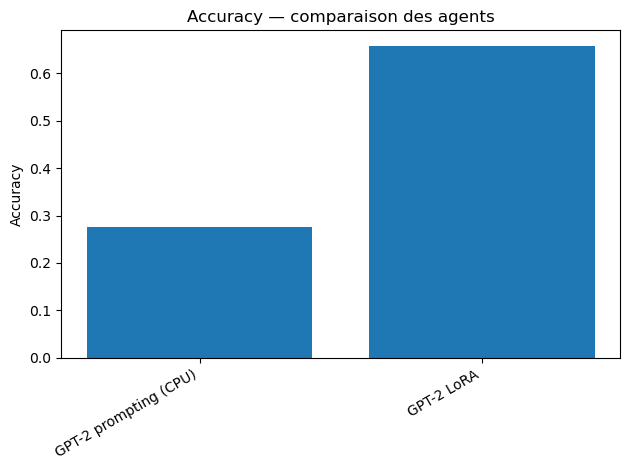

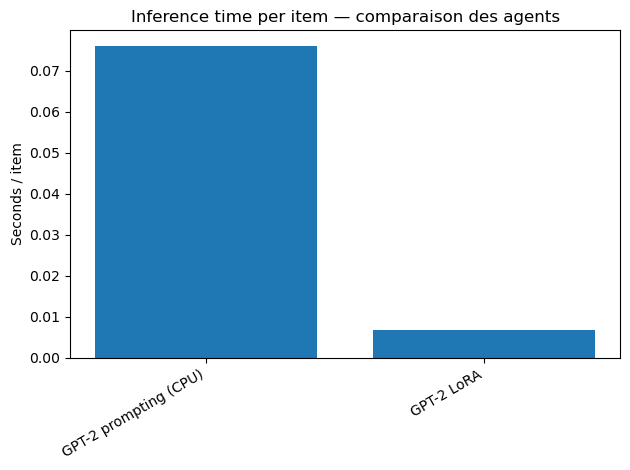

In [21]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Récupérer les dicts de résultats (si une expérience n'a pas été lancée, elle n'existera pas)
results = []
for var_name in ["result_distilbert", "result_prompting", "result_lora"]:
    if var_name in globals():
        results.append(globals()[var_name])

df_results = pd.DataFrame(results)
display(df_results)

# Sauvegarde pour le rapport
out_dir = Path("outputs") / "metrics"
out_dir.mkdir(parents=True, exist_ok=True)
df_results.to_csv(out_dir / "summary_results.csv", index=False)
print("Saved:", out_dir / "summary_results.csv")

# ----- Chart (comparaison rapide) -----
# 1) Accuracy
if "accuracy" in df_results.columns and len(df_results) > 0:
    plt.figure()
    plt.bar(df_results["agent"], df_results["accuracy"])
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Accuracy")
    plt.title("Accuracy — comparaison des agents")
    plt.tight_layout()
    plt.show()

# 2) Temps d'inférence par item (si dispo)
if "inference_time_sec_per_item" in df_results.columns and len(df_results) > 0:
    plt.figure()
    plt.bar(df_results["agent"], df_results["inference_time_sec_per_item"])
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Seconds / item")
    plt.title("Inference time per item — comparaison des agents")
    plt.tight_layout()
    plt.show()


## 7. Discussion and next steps

**What we learned so far**
- DistilBERT (Agent 3) provides a strong supervised baseline for routing, but minority classes (e.g., *General Inquiry*, *Sales and Pre‑Sales*) are harder.
- GPT‑2 prompting (Agent 1) is extremely cheap to set up, but accuracy is typically low without careful prompt design and parsing.
- GPT‑2 + LoRA (Agent 2) is the “middle ground”: it can improve over prompting while staying lighter than full fine‑tuning.

**Recommended next checks**
1. Re‑run evaluation with a larger test subset (e.g., 1k items) for Agent 1 prompting to reduce variance.
2. For Agent 2 LoRA, verify that:
   - LoRA parameters are the only trainable ones (`model.print_trainable_parameters()`),
   - the model uses a valid padding token (`tokenizer.pad_token = eos_token`),
   - training loss decreases over epochs.
3. For Agent 3 DistilBERT, keep:
   - weighted loss or balanced sampling,
   - 3–5 epochs (with early stopping if available),
   - monitoring macro‑F1 in addition to accuracy.
